In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord, ResizeD

# ------------------------------------------------
# 1. Prepare the 2D Datasets and DataLoaders
# ------------------------------------------------

# Define paths to your 2D data directories
train_2d_dir = './dataset/train_new'
val_2d_dir = './dataset/val_new'

# Build the list of 2D training samples.
train_data_2d = []
for patient in os.listdir(train_2d_dir):
    patient_path = os.path.join(train_2d_dir, patient)
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            # We want to add image files that are not ground truth.
            if file.endswith('.nii') and '_gt' not in file:
                image_path = os.path.join(patient_path, file)
                # If file is augmented, insert '_gt' before the '_aug' part.
                if "_aug" in file:
                    base, aug = file.split("_aug", 1)
                    gt_file = base + "_gt" + "_aug" + aug
                else:
                    gt_file = file.replace('.nii', '_gt.nii')
                gt_path = os.path.join(patient_path, gt_file)
                if os.path.exists(gt_path):
                    train_data_2d.append({"image": image_path, "label": gt_path})
                else:
                    print("Warning: No corresponding ground truth for", image_path)
print(f"Found {len(train_data_2d)} 2D training samples.")

# Build the list of 2D validation samples.
val_data_2d = []
for patient in os.listdir(val_2d_dir):
    patient_path = os.path.join(val_2d_dir, patient)
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            # Select files that do NOT have "_gt" in the name.
            if '_gt' not in file:
                image_path = os.path.join(patient_path, file)
                # If the file has an extension, insert '_gt' before the extension.
                if file.endswith('.nii'):
                    gt_file = file.replace('.nii', '_gt.nii')
                else:
                    # Otherwise, simply append '_gt' to the file name.
                    gt_file = file + '_gt'
                gt_path = os.path.join(patient_path, gt_file)
                if os.path.exists(gt_path):
                    val_data_2d.append({"image": image_path, "label": gt_path})
                else:
                    print("Warning: No corresponding ground truth for", image_path)
print(f"Found {len(val_data_2d)} 2D validation samples.")

# Define transforms for both training and validation.
# Here we add a ResizeD transform to force every image to be 352x352.
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(352, 352)),
    ToTensord(keys=["image", "label"]),
])

# Create MONAI datasets.
train_ds_2d = Dataset(data=train_data_2d, transform=transforms)
val_ds_2d = Dataset(data=val_data_2d, transform=transforms)

# Create DataLoaders using a padded collate function.
train_loader_2d = DataLoader(train_ds_2d, batch_size=10, shuffle=True, collate_fn=pad_list_data_collate)
val_loader_2d = DataLoader(val_ds_2d, batch_size=10, shuffle=False, collate_fn=pad_list_data_collate)

# ------------------------------------------------
# 2. Build the 2D U-Net Model and Training Setup
# ------------------------------------------------

in_channels = 1           # grayscale images
out_channels = 4          # e.g., background + 3 regions
initial_features = 48

channels = (initial_features, initial_features*2, initial_features*4, initial_features*8)
strides = (2, 2, 2)
num_res_units = 2

# Use "batch" for normalization.
model = UNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=num_res_units,
    norm="batch",
)

# ------------------------------------------------
# Weighted Cross-Entropy Loss
# ------------------------------------------------
# Define class weights (example values – adjust as needed).
class_weights = torch.tensor([0.2, 0.3, 0.3, 0.2], device="cuda" if torch.cuda.is_available() else "cpu", dtype=torch.float)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ------------------------------------------------
# 3. Training Loop Using Weighted Cross-Entropy Loss
# ------------------------------------------------

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_data in train_loader_2d:
        inputs = batch_data["image"].to(device)   # shape: (B, 1, 352, 352)
        labels = batch_data["label"].to(device)     # shape: (B, 1, 352, 352)
        # Squeeze out the channel dimension so labels become (B, 352, 352) with integer values.
        labels = labels.squeeze(1).long()
        
        optimizer.zero_grad()
        outputs = model(inputs)                     # outputs: (B, 4, 352, 352)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader_2d)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_loss:.4f}")
    
    # Validation loop.
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_data in val_loader_2d:
            val_inputs = val_data["image"].to(device)
            val_labels = val_data["label"].to(device).squeeze(1).long()
            val_outputs = model(val_inputs)
            loss_val = loss_function(val_outputs, val_labels)
            val_loss += loss_val.item()
        avg_val_loss = val_loss / len(val_loader_2d)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")

# ------------------------------------------------
# 4. Plot Loss vs. Epoch (Logarithmic Scale)
# ------------------------------------------------

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label="Training Loss", marker="o")
plt.plot(epochs_range, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


2025-02-25 19:05:47.359278: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 19:05:47.398128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 19:05:47.398151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 19:05:47.398169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 19:05:47.405645: I tensorflow/core/platform/cpu_feature_g

Found 6104 2D training samples.
Found 376 2D validation samples.
Epoch 1/30, Average Training Loss: 0.7122
Epoch 1/30, Validation Loss: 0.3199
Epoch 2/30, Average Training Loss: 0.1858
Epoch 2/30, Validation Loss: 0.1281
Epoch 3/30, Average Training Loss: 0.0879
Epoch 3/30, Validation Loss: 0.0789
Epoch 4/30, Average Training Loss: 0.0560
Epoch 4/30, Validation Loss: 0.0561
Epoch 5/30, Average Training Loss: 0.0389
Epoch 5/30, Validation Loss: 0.0470
Epoch 6/30, Average Training Loss: 0.0295
Epoch 6/30, Validation Loss: 0.0375
Epoch 7/30, Average Training Loss: 0.0240
Epoch 7/30, Validation Loss: 0.0408
Epoch 8/30, Average Training Loss: 0.0198
Epoch 8/30, Validation Loss: 0.0430
Epoch 9/30, Average Training Loss: 0.0173
Epoch 9/30, Validation Loss: 0.0398
Epoch 10/30, Average Training Loss: 0.0152
Epoch 10/30, Validation Loss: 0.0340
Epoch 11/30, Average Training Loss: 0.0133
Epoch 11/30, Validation Loss: 0.0373
Epoch 12/30, Average Training Loss: 0.0119
Epoch 12/30, Validation Loss: 

NameError: name 'plt' is not defined

Model checkpoint saved.


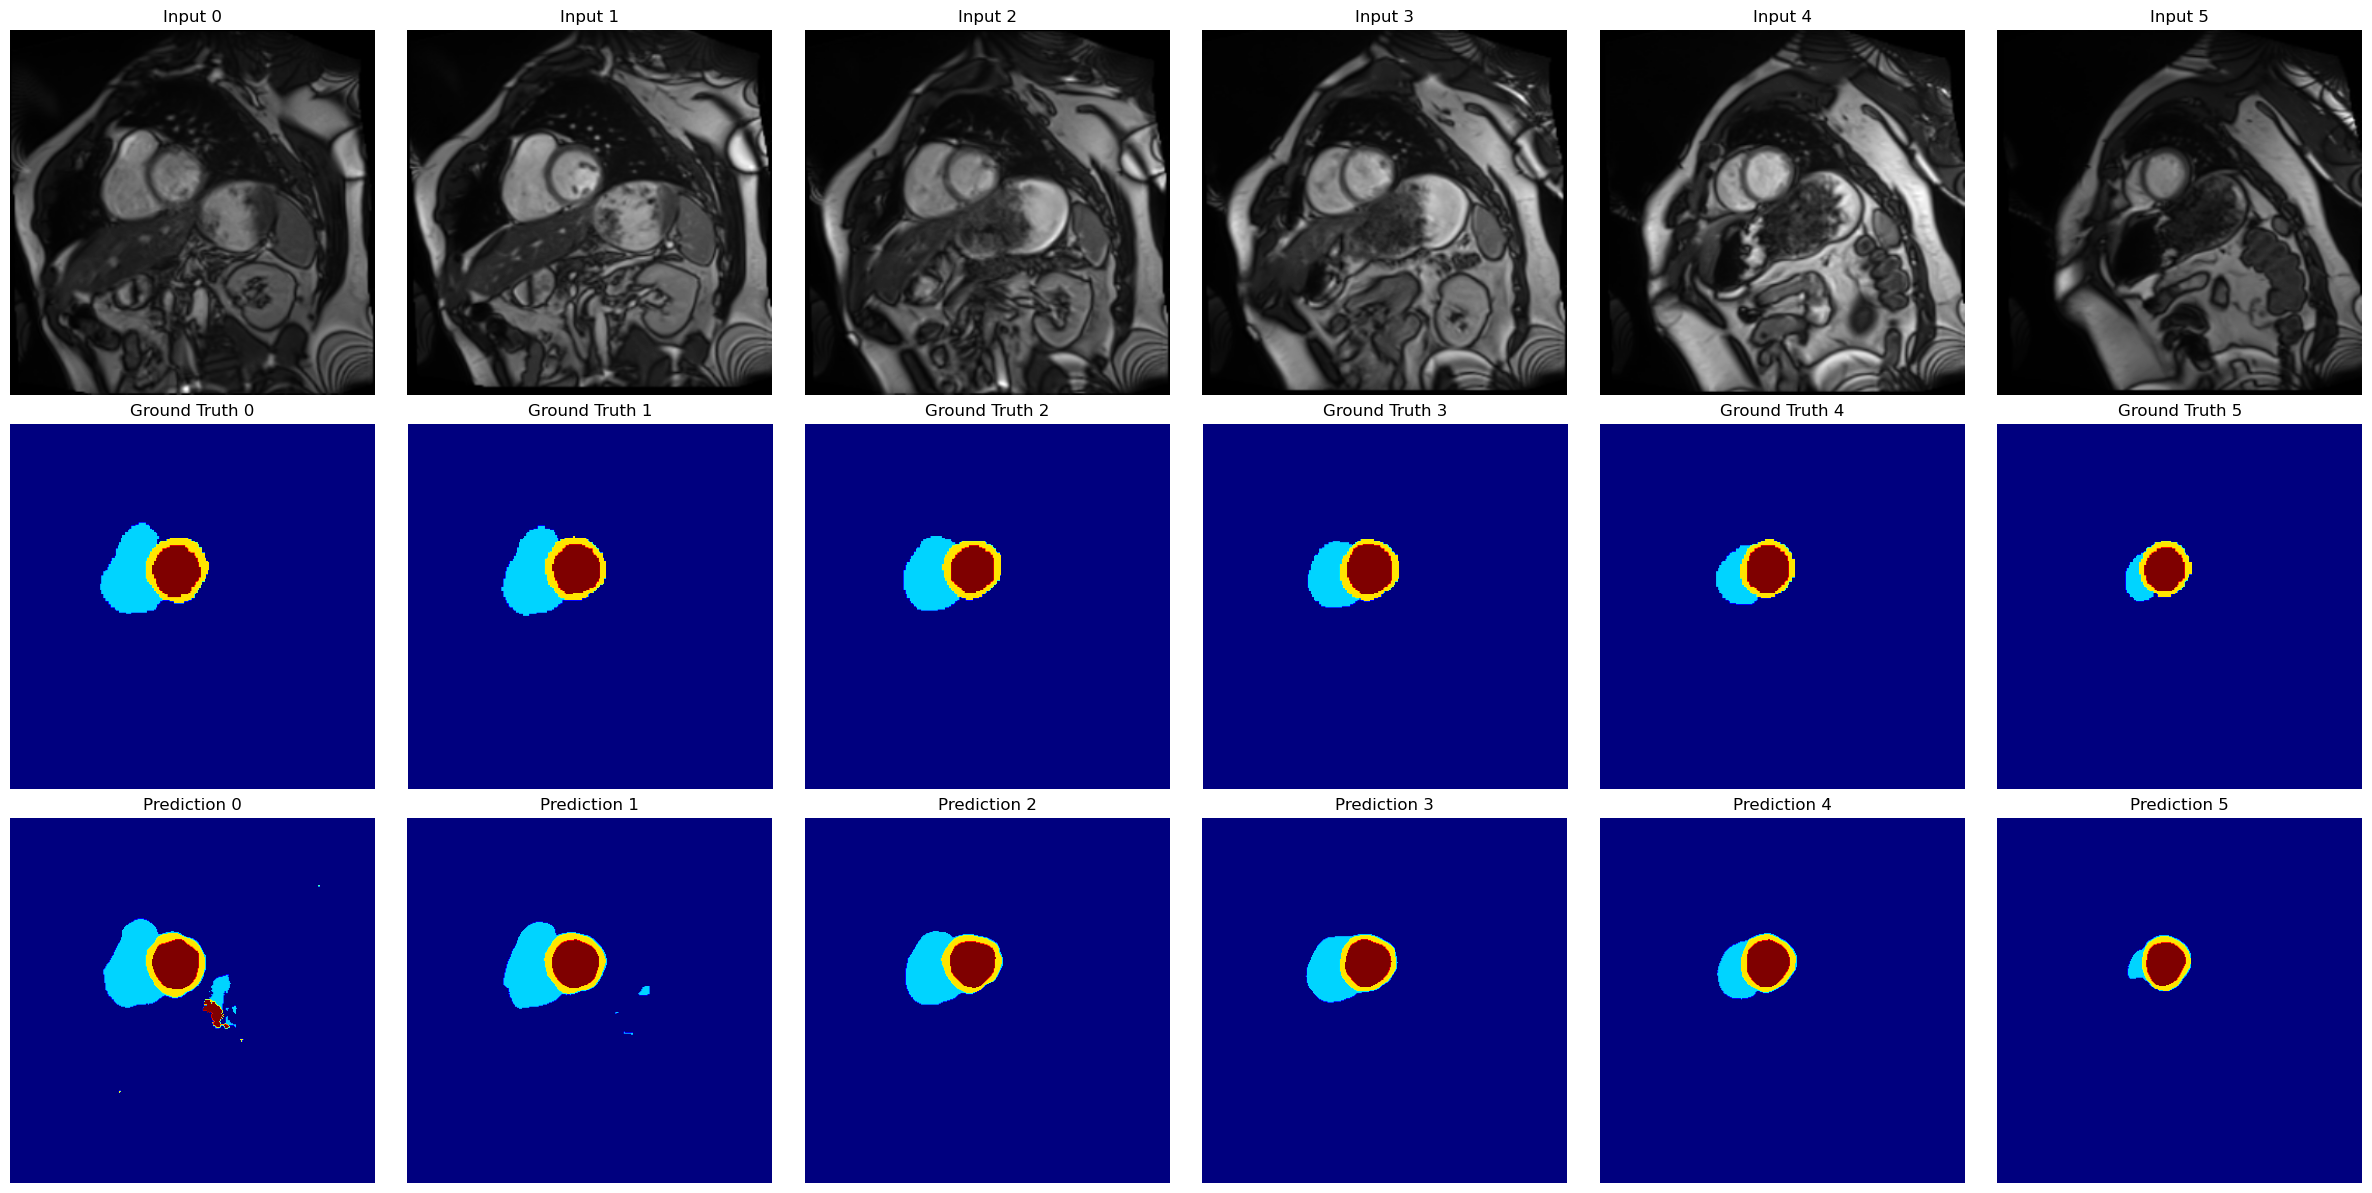

/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Dice Score: 0.7333
Hausdorff Distance (95th percentile): 60.0396
Pixel-wise Accuracy: 0.9921


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.metrics import DiceMetric, HausdorffDistanceMetric

# 1. Save the model checkpoint.
torch.save(model.state_dict(), "2d_unet_checkpoint_model_augmentation_celoss_30epochs.pth")
print("Model checkpoint saved.")

# 2. Visualize predictions on a validation batch.
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader_2d))
    inputs = batch["image"].to(device)
    labels = batch["label"].to(device)
    outputs = model(inputs)
    # Get the predicted segmentation as the argmax over the channel dimension.
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

# Move inputs and labels to CPU for visualization.
inputs = inputs.cpu().numpy()   # shape: (B, 1, H, W)
labels = labels.cpu().numpy()   # shape: (B, 1, H, W)

# Number of samples to display.
num_to_show = min(6, inputs.shape[0])
fig, axs = plt.subplots(3, num_to_show, figsize=(4*num_to_show, 12))
for i in range(num_to_show):
    # Input image.
    axs[0, i].imshow(inputs[i, 0, :, :], cmap="gray")
    axs[0, i].set_title(f"Input {i}")
    axs[0, i].axis("off")
    # Ground truth.
    axs[1, i].imshow(labels[i, 0, :, :], cmap="jet")
    axs[1, i].set_title(f"Ground Truth {i}")
    axs[1, i].axis("off")
    # Prediction.
    axs[2, i].imshow(preds[i, :, :], cmap="jet")
    axs[2, i].set_title(f"Prediction {i}")
    axs[2, i].axis("off")
plt.tight_layout()
plt.show()

# 3. Evaluate the model on the full validation set.
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
hd_metric = HausdorffDistanceMetric(include_background=True, percentile=95)

total_correct = 0
total_pixels = 0

model.eval()
with torch.no_grad():
    for val_batch in val_loader_2d:
        val_inputs = val_batch["image"].to(device)
        val_labels = val_batch["label"].to(device)
        val_outputs = model(val_inputs)
        # Obtain predictions.
        preds_batch = torch.argmax(val_outputs, dim=1, keepdim=True)  # shape: (B, 1, H, W)
        # Update metrics.
        dice_metric(y_pred=preds_batch, y=val_labels)
        hd_metric(y_pred=preds_batch, y=val_labels)
        # Pixel-wise accuracy.
        total_correct += (preds_batch == val_labels).sum().item()
        total_pixels += torch.numel(val_labels)

dice_score = dice_metric.aggregate().item()
hd_score = hd_metric.aggregate().item()
accuracy = total_correct / total_pixels

print(f"Dice Score: {dice_score:.4f}")
print(f"Hausdorff Distance (95th percentile): {hd_score:.4f}")
print(f"Pixel-wise Accuracy: {accuracy:.4f}")


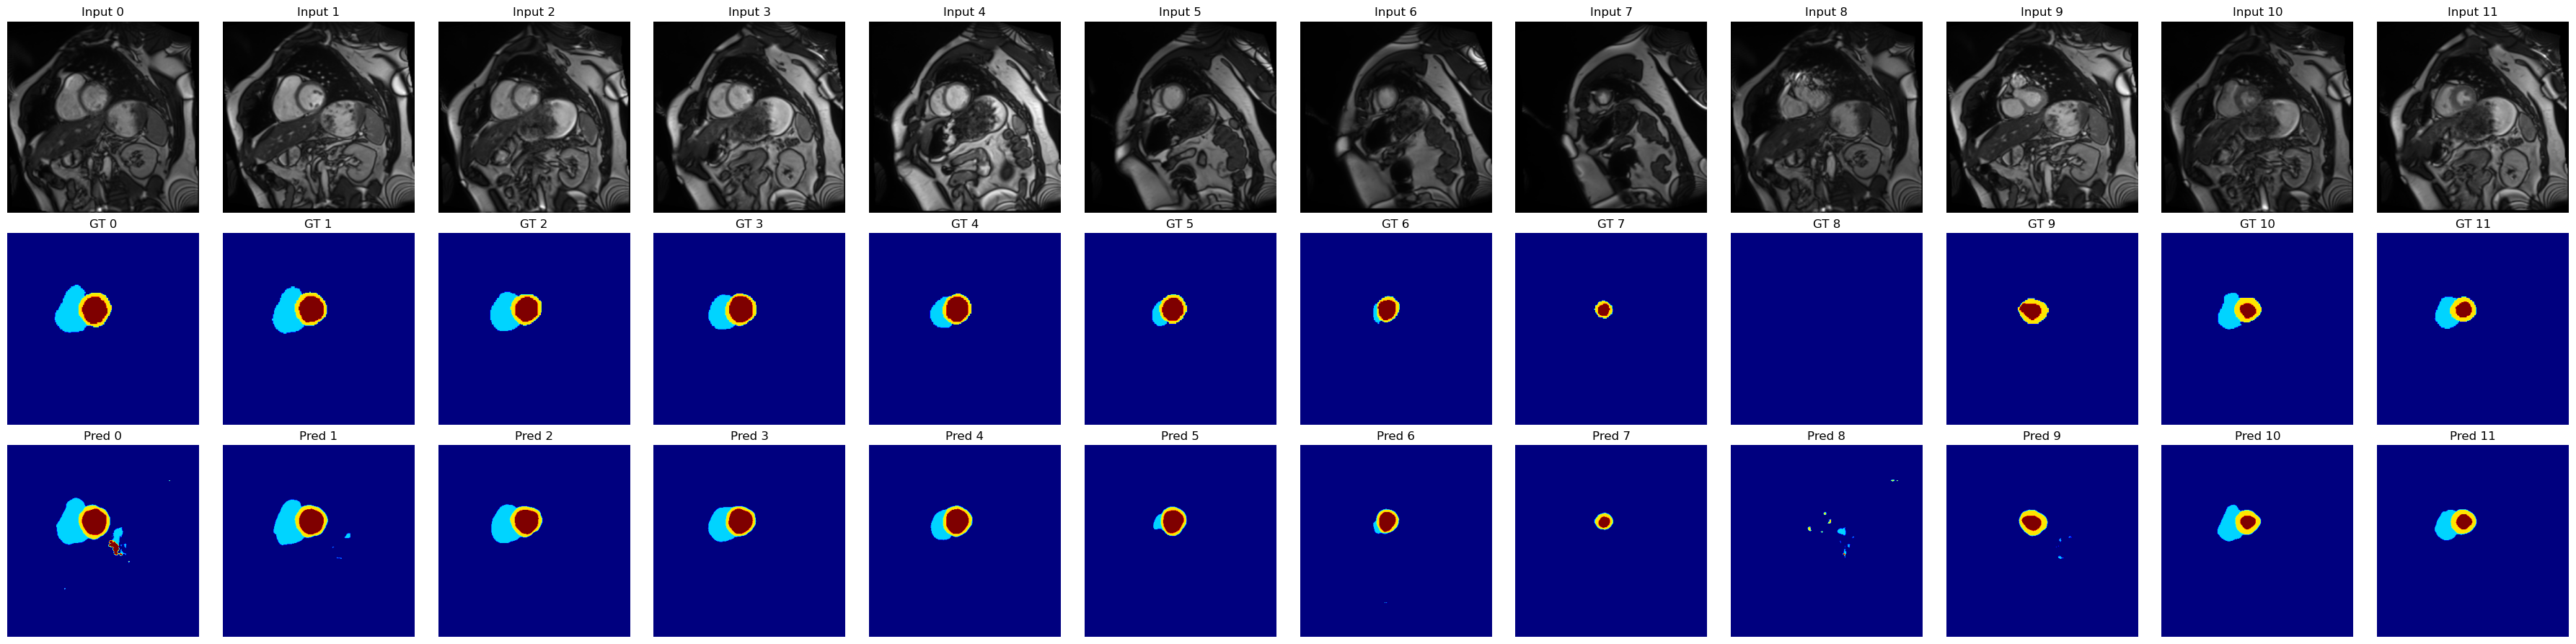

Dice Score: 0.7333
Hausdorff Distance (95th percentile): 60.0396
Pixel-wise Accuracy: 0.9921


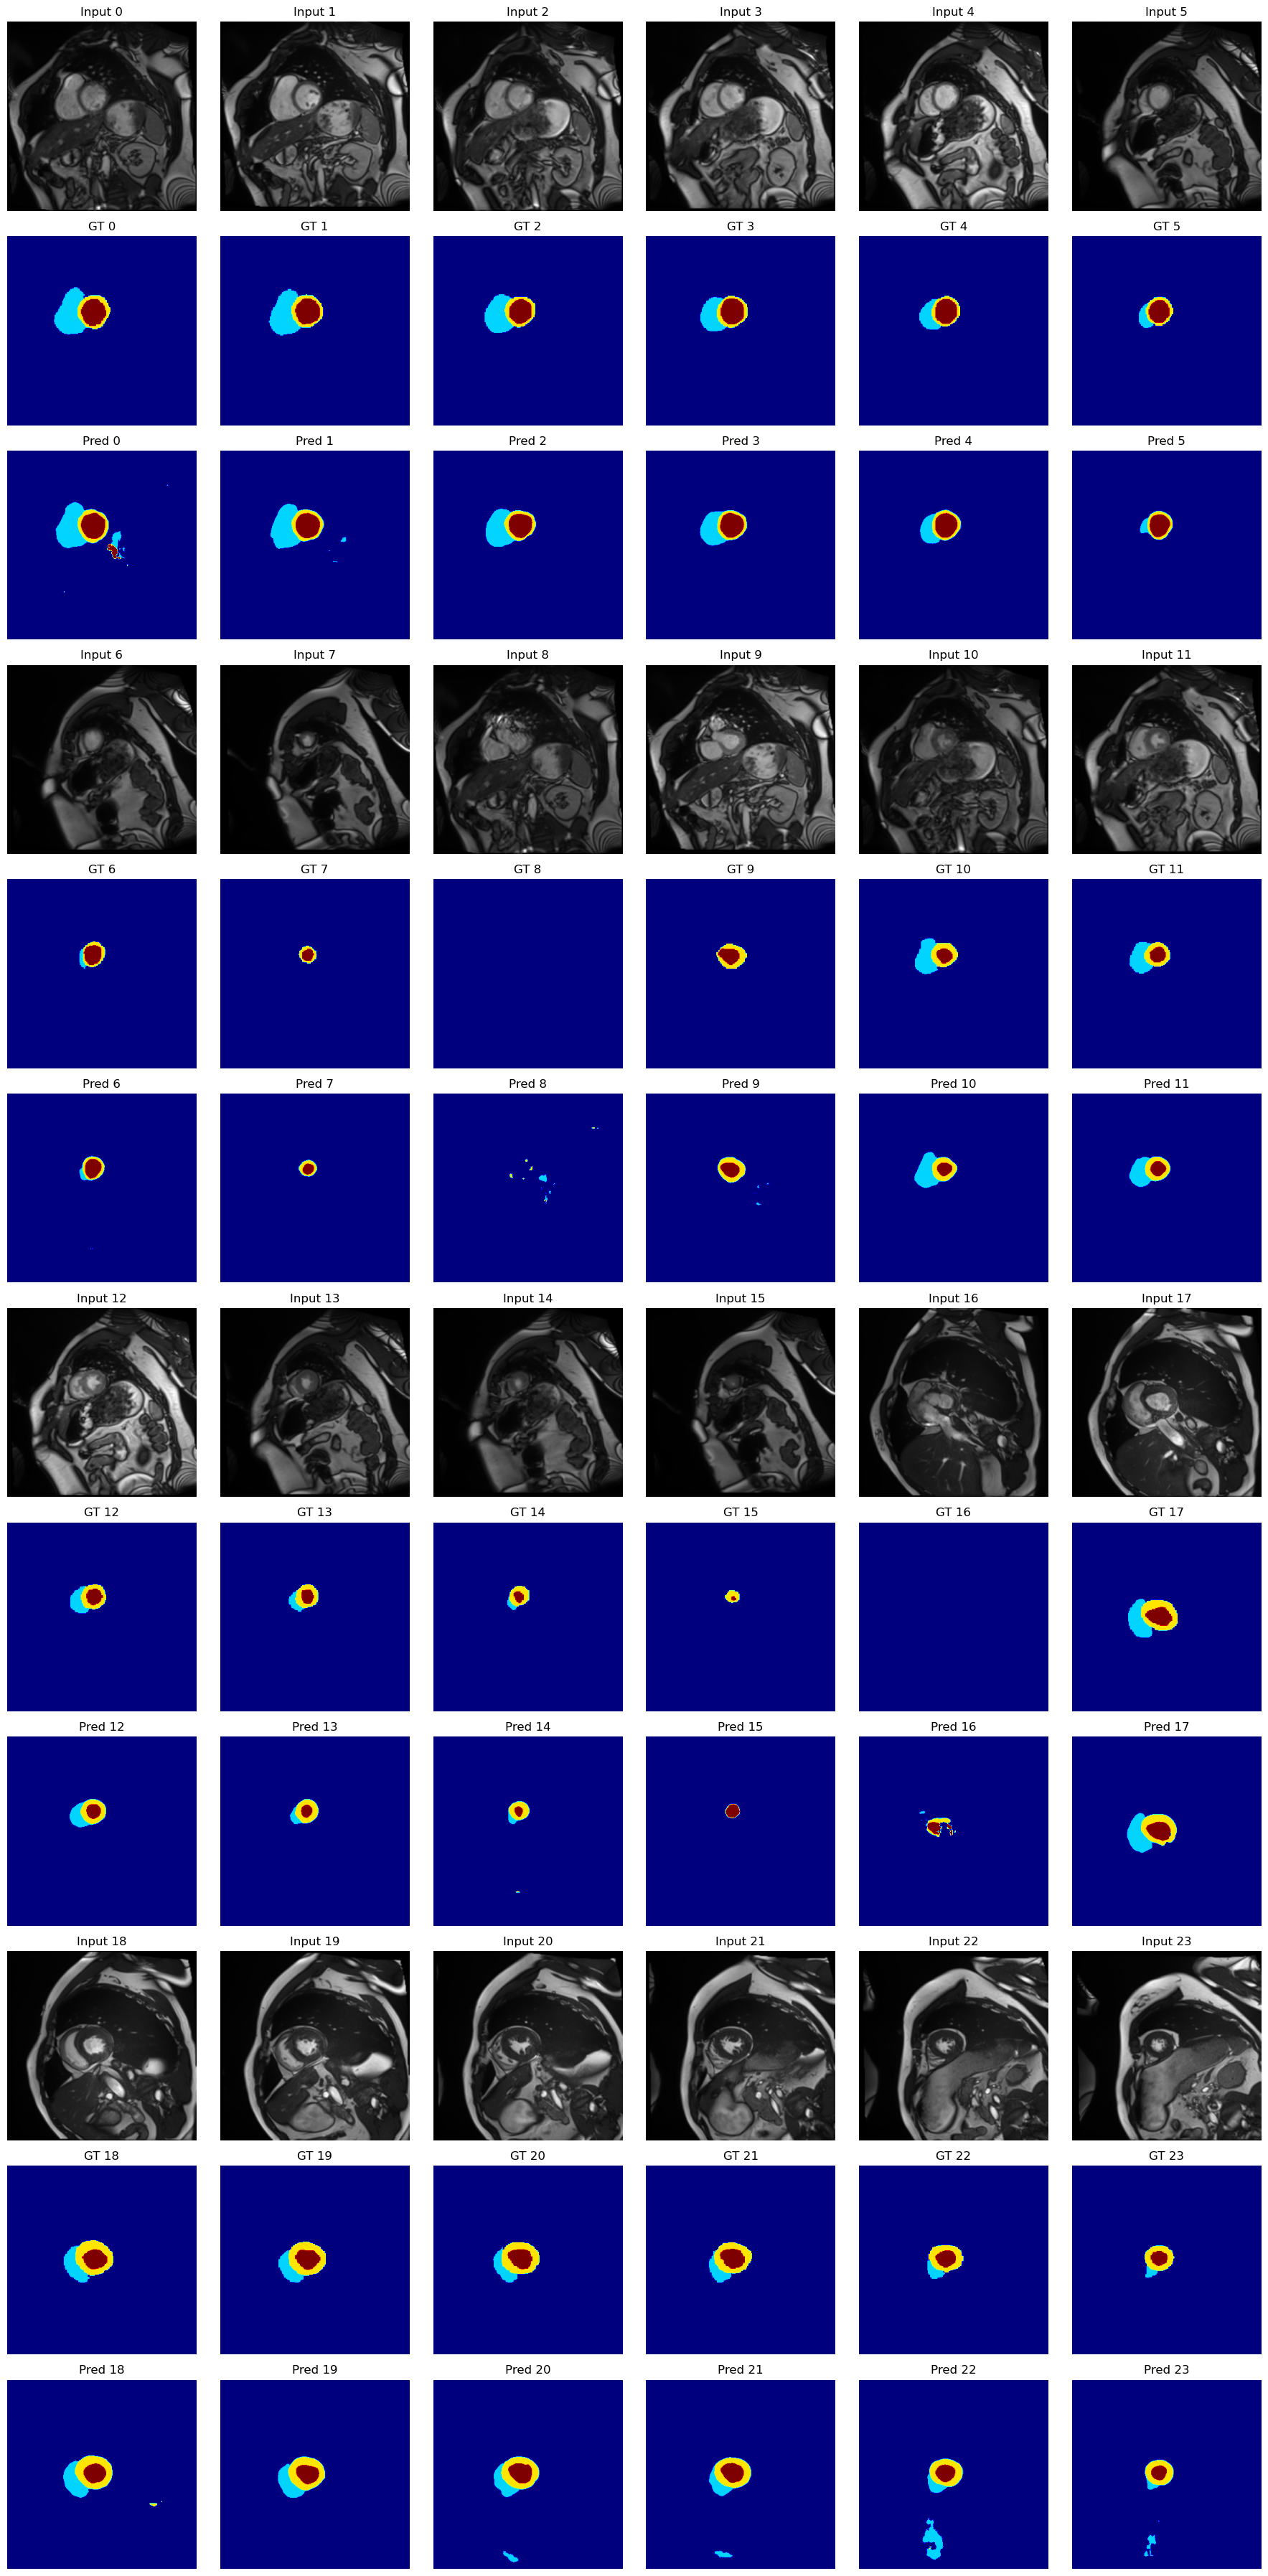

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Collect up to 24 samples from the validation DataLoader.
all_inputs = []
all_labels = []
all_preds = []

desired_samples = 24  # 4 rows of 6 samples each
with torch.no_grad():
    for batch in val_loader_2d:
        inputs = batch["image"].to(device)      # shape: (B, 1, H, W)
        labels = batch["label"].to(device)        # shape: (B, 1, H, W)
        outputs = model(inputs)                   # shape: (B, 4, H, W)
        preds = torch.argmax(outputs, dim=1)       # shape: (B, H, W)
        for i in range(inputs.shape[0]):
            all_inputs.append(inputs[i].cpu().numpy())
            all_labels.append(labels[i].cpu().numpy())
            all_preds.append(preds[i].cpu().numpy())
            if len(all_inputs) >= desired_samples:
                break
        if len(all_inputs) >= desired_samples:
            break

n_samples = len(all_inputs)
if n_samples == 0:
    raise ValueError("No samples collected from the validation loader.")

# We want to arrange samples in a grid with 6 columns.
n_cols = 6
n_rows_samples = n_samples // n_cols  # should be 4 if we collected 24 samples.
total_plot_rows = n_rows_samples * 3   # each sample is displayed as 3 images vertically

fig, axs = plt.subplots(total_plot_rows, n_cols, figsize=(3*n_cols, 3*total_plot_rows))

# Loop over each sample and assign its input, ground truth, and prediction
for idx in range(n_samples):
    group = idx // n_cols        # which sample row group (0, 1, 2, 3)
    col = idx % n_cols           # column index in the grid
    row_input = group * 3        # row for the input image
    row_gt = row_input + 1       # row for the ground truth
    row_pred = row_input + 2     # row for the prediction

    # Plot the input image (assumed shape: (1, H, W)).
    axs[row_input, col].imshow(all_inputs[idx][0, :, :], cmap="gray")
    axs[row_input, col].set_title(f"Input {idx}")
    axs[row_input, col].axis("off")
    
    # Plot the ground truth (assumed shape: (1, H, W)).
    axs[row_gt, col].imshow(all_labels[idx][0, :, :], cmap="jet")
    axs[row_gt, col].set_title(f"GT {idx}")
    axs[row_gt, col].axis("off")
    
    # Plot the prediction (assumed shape: (H, W)).
    axs[row_pred, col].imshow(all_preds[idx], cmap="jet")
    axs[row_pred, col].set_title(f"Pred {idx}")
    axs[row_pred, col].axis("off")

plt.tight_layout()
plt.show()


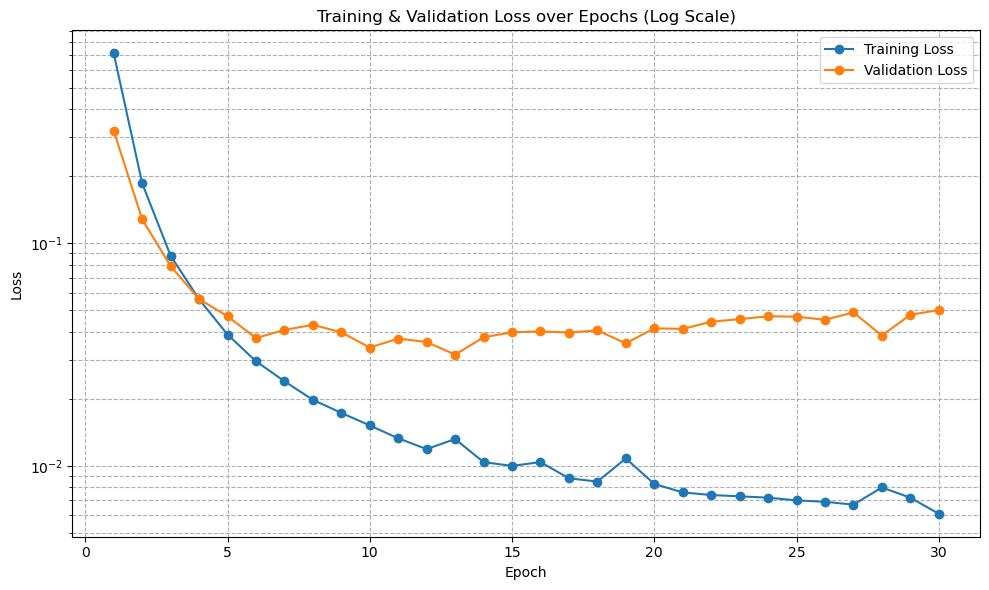

In [3]:
import matplotlib.pyplot as plt

# Provided loss values for 30 epochs.
train_losses = [
    0.7122, 0.1858, 0.0879, 0.0560, 0.0389, 0.0295, 0.0240, 0.0198, 0.0173, 0.0152,
    0.0133, 0.0119, 0.0132, 0.0104, 0.0100, 0.0104, 0.0088, 0.0085, 0.0108, 0.0083,
    0.0076, 0.0074, 0.0073, 0.0072, 0.0070, 0.0069, 0.0067, 0.0080, 0.0072, 0.0061
]
val_losses = [
    0.3199, 0.1281, 0.0789, 0.0561, 0.0470, 0.0375, 0.0408, 0.0430, 0.0398, 0.0340,
    0.0373, 0.0360, 0.0316, 0.0378, 0.0398, 0.0402, 0.0397, 0.0406, 0.0355, 0.0415,
    0.0412, 0.0444, 0.0456, 0.0470, 0.0468, 0.0453, 0.0489, 0.0385, 0.0477, 0.0501
]

# Define the epochs range (1 to 30).
epochs_range = range(1, 31)

# Create the plot.
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label="Training Loss", marker="o")
plt.plot(epochs_range, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs (Log Scale)")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()